# 游댌 Named Entity Recognition (NER) System

**A comprehensive implementation of NER using Conditional Random Fields**

En este proyecto, implementamos un sistema de Reconocimiento de Entidades Nombradas (NER) utilizando Campos Aleatorios Condicionales (CRF). El objetivo es identificar y clasificar entidades en texto, como nombres de personas, organizaciones y ubicaciones.
INTRO:
1. Todas las funciones y clases que se han implementado en este proyecto est치n en el archivo `Functions.py`.
2. Para ahorrar tiempo, hemos guardado los modelos ya preentrenados en las carpetas repectivas de cada idioma. En el script actual se cargan los mejores modelos entrenados para cada idioma.
3. El output de cada entrenamiento (gridsearch) para cada idioma tambi칠n est치n dentro de las carpetas respectivas, en formato *.txt*.

## Authors
- Taisiia Prymak
- Jiahui Chen

## Date
Mayo 2025 - Procesamiento de Lenguaje Humano (PLH) - Universidad polit칠cnica de Barcelona.

## Index
1. [An치lisis exploratorio de los datos](#1-an치lisis-exploratorio-de-los-datos)
2. [Explorando los posibles gazzeters](#2-explorando-los-posibles-gazzeters)
3. [Preprocesamiento de Data para CRF Model](#3-preprocesamiento-de-data-para-crf-model)
4. [Train a CRF Model for NER](#4-train-a-crf-model-for-ner)
5. [NER Evaluation](#5-ner-evaluation)
6. [Feature Combination Analysis](#6-feature-combination-analysis)
7. [Full Analysis with Optimized Features](#7-full-analysis-with-optimized-features)
8. [Experiment with Different Tag Encoding Schemes](#8-experiment-with-different-tag-encoding-schemes)

In [3]:

from Funciones import *

## 1. An치lisis exploratorio de los datos

First, we'll load data from the conll2002 corpus for Spanish NER.

In [2]:
# CARGAR PRIMERO LOS DATOS DEL TRAIN PARA HACER UN ANALISIS EXPLORATORIO.
train = conll2002.iob_sents('esp.train')
val = conll2002.iob_sents('esp.testa')


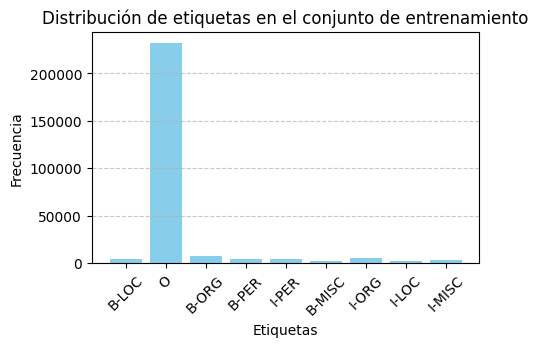

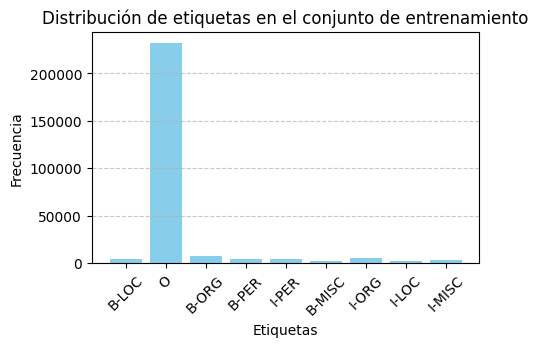

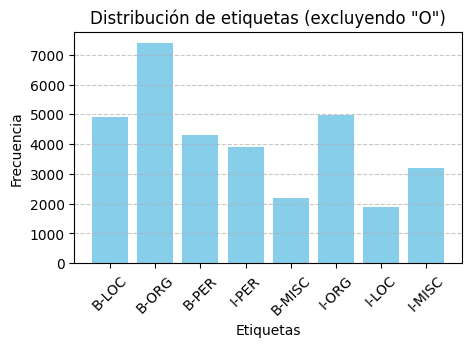

In [3]:
# Contar las etiquetas en el conjunto de entrenamiento
tag_counts = Counter(tag for sentence in train for _, _, tag in sentence)

# Graficar la distribuci칩n de todas las etiquetas
plot_tag_distribution(tag_counts, 'Distribuci칩n de etiquetas en el conjunto de entrenamiento')

# Graficar la distribuci칩n excluyendo la etiqueta "O"
plot_tag_distribution(tag_counts, 'Distribuci칩n de etiquetas (excluyendo "O")', exclude_tag="O")


## 2. Explorando los posibles gazzeters

Se va a implementar la clase encargada de construir el diccionario de features sobre los cuales se va a entrenar el modelo CRF.

La clase de funciones de caracter칤sticas para NER incluye:

- **Caracter칤sticas b치sicas de las palabras:** se van a incluir las caracter칤sticas que vienen por defecto en nltk, ampliando un poco m치s de informaci칩n que podemos saber de la palabra. Como por ejemplo, si est치 formada toda por letras mayusculas, si tiene signos de puntuaci칩n, etc.

- **Caracter칤sticas contextuales:** incluye aparte de la palabra actual, la palabra que le precede y la posterior.
- **Caracter칤sticas de etiquetas POS:** incluye el POS tag de la palabra actual y el de las palabras del contexto.
- **Caracter칤sticas de lemas:** incluye el lema de la palabra actual.
- **Caracter칤sticas espec칤ficas:** Gazetters, listas de patrones espec칤ficos.

Esta clase es llamada **OptimizedFeatFunc**, tambi칠n est치 optimizada deforma que cada vez que el CRFTagger vuelve a pasar por la misma frase la clase retorna el diccionario de caracter칤sticas ya calculado anteriormente, esto evita volver a crear el diccionario.


Las caracter칤sticas espec칤ficas se van a determinar a partir del train. Se van a formar las listas Gazzeters a partir de los patrones m치s comunes encontrados. Buscamos las palabras m치s comunes que aparecen con las etiquetas LOC, ORG, y MISC y, tambi칠n, los trigramas m치s comunes que treceden estas etiquetas. De esta manera el modelo podr칤a aprender los patrones m치s comunes.

In [4]:
train_data = [([token for token, _, _ in sentence], [tag for _, _, tag in sentence]) for sentence in train]

# Crear el extractor y procesar los datos
extractor = SimpleGazetteerExtractor()
extractor.extract_patterns_and_trigrams(train_data, train)

# Imprimir los patrones y trigramas encontrados
extractor.print_patterns_and_trigrams()


=== Top 30 Patrones de LOC ===
Madrid: 221
Espa침a: 147
Barcelona: 99
Par칤s: 97
Francia: 58
L칤bano: 47
Badajoz: 43
Santander: 40
M칠rida: 40
C치ceres: 40
Europa: 37
Brasil: 37
Catalu침a: 35
Sevilla: 32
M칠xico: 32
Oviedo: 32
Bruselas: 31
Argentina: 30
Navarra: 30
EEUU: 29
Pamplona: 28
Valencia: 27
R칤o de Janeiro: 27
Israel: 26
Bilbao: 26
Extremadura: 25
San Sebasti치n: 25
Vitoria: 25
M치laga: 25
Nueva York: 25

=== Top 30 Patrones de ORG ===
EFE: 905
Gobierno: 237
PP: 152
EFECOM: 85
UE: 77
Real Madrid: 73
Efe: 70
Valencia: 67
PSOE: 64
Estado: 63
Ej칠rcito: 59
Congreso: 57
Estados Unidos: 55
China: 47
Ejecutivo: 47
Ayuntamiento: 41
ESL: 39
Telef칩nica: 38
ONU: 34
IU: 33
Uni칩n Europea: 33
CiU: 32
Guardia Civil: 31
Hizbul치: 30
Francia: 30
ETA: 29
Espa침a: 29
Parlamento: 28
Administraci칩n: 27
Israel: 26

=== Top 30 Patrones de MISC ===
Liga de Campeones: 35
Internet: 33
Interior: 33
Cultura: 18
Medio Ambiente: 18
Agricultura: 15
Educaci칩n: 13
Exteriores: 12
Copa de Europa: 12
Justicia: 12
Liga: 12
C

Existe un solapamiento entre las palabras m치s comunes que identifican los lugares y las organizaciones. Por ejemplo, "Valencia" puede estar identificada en el texto como 'B-LOC' o 'B-ORG'. Decidimos no incluir estas palabras que son comunes para las dos etiquetas.

Si se incluyen las palabras m치s comunes para la categor칤a 'B-MISC' pueden introducir mucho ruido en el modelo ya que no se presenta un patr칩n espec칤fico claro, estas palabras podr칤an pertenecer perfectamente a otras categorias.

Adem치s, como podemos ver, los trigramas que preceden las etiquetas de inicio de organizaci칩n presentan mucha variablidad, no existe un patr칩n claro que puede identificar rapidamente la continuaci칩n de las entidades que son organizaciones. A칰n m치s variablilidad presentan los trigramas precedentes a los lugares y los micel치nos, se decide que estos no valen la pena a ser incluidos ya que, tambi칠n, podrian agregar ruido al modelo.


## 3. Preprocesamiento de Data para CRF Model

Now let's prepare our data for the CRF model, including lemmatization.

In [5]:

processed_train = prepare_data_for_crf(train, include_lemmas=True)
preprocessed_val = prepare_data_for_crf(val, True)


# Show the first processed sentence
print("Original:")
print(train[0])
print("\nProcessed (with lemmas):")
print(processed_train[0])


Original:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]

Processed (with lemmas):
[(('Melbourne', 'NP', 'Melbourne'), 'B-LOC'), (('(', 'Fpa', '('), 'O'), (('Australia', 'NP', 'Australia'), 'B-LOC'), ((')', 'Fpt', ')'), 'O'), ((',', 'Fc', ','), 'O'), (('25', 'Z', '25'), 'O'), (('may', 'NC', 'may'), 'O'), (('(', 'Fpa', '('), 'O'), (('EFE', 'NC', 'EFE'), 'B-ORG'), ((')', 'Fpt', ')'), 'O'), (('.', 'Fp', '.'), 'O')]


Es importante destacar que el usuario debe tener en cuenta que los argumentos de la lematizaci칩n en el preprocesamiento del texto ("include_lemmas") y en la instancia de la clase OptimizedFeatFunc ("use_lemas") deben de ser los mismos (los dos a True o los dos a False) para el correcto funcionamiento.

## 4. Train a CRF Model for NER

Let's train a small CRF model using our feature function and prepared data.

In [6]:
# Create our feature function
feature_func = OptimizedFeatFunc(True,True, True, True, True)

# Initialize CRF tagger with our feature function
crf_tagger = CRFTagger(feature_func=feature_func)

# For demonstration, train on a small subset
crf_tagger.train(processed_train, 'example_model.crf.tagger')

print("CRF model trained!")

KeyboardInterrupt: 

## 5. NER Evaluation
En este apartado implementamos la evaluaci칩n del modelo. La evaluaci칩n se realiza sobre el conjunto de test a nivel entidades para tener una medida m치s robusta y no a nivel de tokens. Esto es importante ya que el modelo puede inventar nuevas entidades y no se puede evaluar su rendimiento a nivel de tokens. La evaluaci칩n se realiza utilizando la m칠trica de F1-score, que es una medida com칰nmente utilizada en tareas de NER. Comentar que no se ha considerado las entidades predichas parciales (las que tienen mitad o una parte de la etiqueta correcta), ya que consideramos m치s objetivo tener una perspectiva m치s estricta de la evaluaci칩n. En este caso, se considera que una entidad es correcta si coincide completamente con la etiqueta esperada.

La implementaci칩n ha seguido los siguientes pasos:
1. Extracci칩n de las entidades del conjunto de predicciones, seg칰n el tag, para despu칠s compararlas con las entidades del conjunto de test extra칤das a partir de BIO (tag original).
2. Funciones auxiliares que ayudan a construir la matriz de confusion.
3. Las funciones principales que construyen el proceso de la evaluaci칩n, donde est치 la funci칩n de comparaci칩n entre dos sets y el c치lculo de la m칠trica F1-score (entre otras m칠tricas).

El calculo de las m칠tricas se han realizado de la siguiente manera:


**Precisi칩n (Precision):**
$$\text{Precision} = \frac{\text{True Positives}}{\text{Total Prediccions}}$$

El Total Predicciones incluye tanto las entidades que fueron correctamente identificadas como las que no lo fueron, adem치s tambi칠n los que ha inventado el modelo, pero no se encuentran en el gold.

**Recall (Exhaustividad):**
$$\text{Recall} = \frac{\text{True Positives}}{\text{Total Gold}}$$

Total Gold incluye todas las entidades correctamente predichas y las que no fueron identificadas por el modelo. Tambi칠n las que est치n en el gold pero no fueron predichas por el modelo.

**F1-Score:**
$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

El F1-score es la media arm칩nica entre la precisi칩n y el recall, proporcionando una 칰nica m칠trica que equilibra ambos aspectos. 

In [ ]:
# Replace the token-level accuracy evaluation with entity-level evaluation
entity_metrics = entity_level_accuracy(crf_tagger, preprocessed_val)  # Changed from trained_tagger to crf_tagger

print("Entity-Level Evaluation:")
print(f"Precision: {entity_metrics['precision']:.4f}")
print(f"Recall: {entity_metrics['recall']:.4f}")
print(f"F1 Score: {entity_metrics['f1']:.4f}")

# For comparison, also show the token-level accuracy
# First prepare test data in the format expected by the CRF tagger
token_accuracy = crf_tagger.accuracy(preprocessed_val)  # Changed from trained_tagger to crf_tagger
print(f"\nToken-Level Accuracy: {token_accuracy:.4f}")

'# Replace the token-level accuracy evaluation with entity-level evaluation\nentity_metrics = entity_level_accuracy(crf_tagger, preprocessed_val)  # Changed from trained_tagger to crf_tagger\n\nprint("Entity-Level Evaluation:")\nprint(f"Precision: {entity_metrics[\'precision\']:.4f}")\nprint(f"Recall: {entity_metrics[\'recall\']:.4f}")\nprint(f"F1 Score: {entity_metrics[\'f1\']:.4f}")\n\n# For comparison, also show the token-level accuracy\n# First prepare test data in the format expected by the CRF tagger\ntoken_accuracy = crf_tagger.accuracy(preprocessed_val)  # Changed from trained_tagger to crf_tagger\nprint(f"\nToken-Level Accuracy: {token_accuracy:.4f}")'

## 6. Feature Combination Analysis

Let's evaluate different combinations of features to find the optimal configuration using entity-level evaluation metrics instead of token-level accuracy.

1. PARA SACAR EL MEJOR MODELO SE EVALUA CON LA DATA DE VALIDACI칍N, Y CON EL MEJOR MODELO, PREDECIR PARA LOS TESTS.
2. Debido a la limitaci칩n en el tiempo no se ha podido llevar a cabo un entrenamiento para todas las posibles combinaciones de los features, aunque hemos decidido agrupar los features para facilitarlo, ya que se necesita bastante tiempo probar las 31 combinaciones. Entonces hemos decidido primero encontrar el mejor modelo con solo feature y fijar ese feature para despu칠s a침adir los otros features, despu칠s fijando los dos mejores y as칤 hasta llegar el modelo completo. El mejor modelo ser치 el que tenga el mejor f1-score. 


**El mejor modelo elegido es el que utiliza 4 caracter칤sticas 'Basic', 'Context_Words', 'Lemmas' y 'Specific'.**

### An치lisis de los pesos entrenados por el modelo: 

Cada vez a침adiendo m치s informaci칩n el modelo parece mejorar su capacidad predictiva, pero el modelo con 5 features da un peor rendimiento que el modelo con 4 features. Lo que vemos es que agregando al mejor modelo, que tiene las features 'Basic', 'Context_Words', 'Lemmas' y 'Specific', el contexto de las POS tags empeora el rendimiento.

Podemos fijarnos en el modelo entrenado con todas las features de la clase OptimizedFeatFunc y analizar as칤 el peso que le aporta el modelo a cada feature, y la import치ncia que tiene esta, sobretodo de la feature 'Prev_POS_2',"Prev_POS_1", "POS","next_POS_1"y"next_POS_2".

In [ ]:
import pycrfsuite

tagger = pycrfsuite.Tagger()
tagger.open('Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger')
weights = tagger.info().state_features

In [ ]:
feature_general = ["POS"]#'Prev_POS_2', "Prev_POS_1",, "next_POS_1", "next_pos_2"
for k,v in tagger.info().state_features.items():
    e, l = k
    if ":" in e:
        e = e.split(":")[0] #mostar solo aquellas k, v que tienen como e in feature general
        if e in feature_general:
            print(k, v)

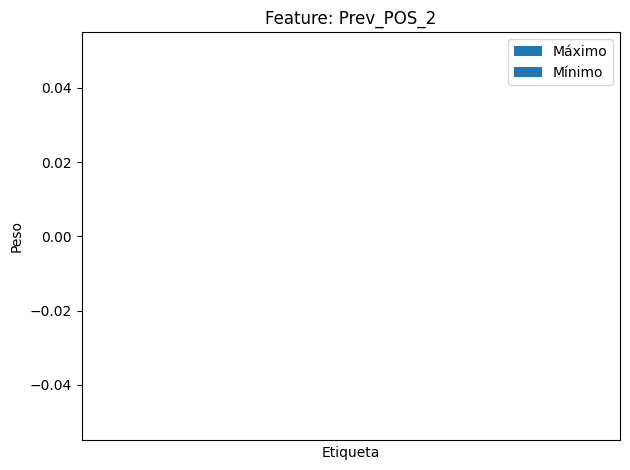

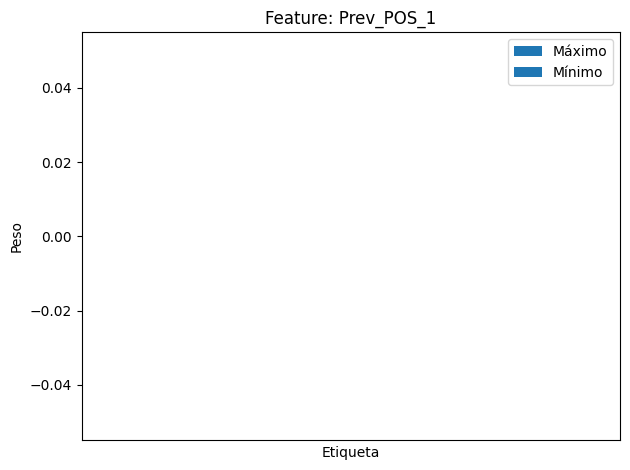

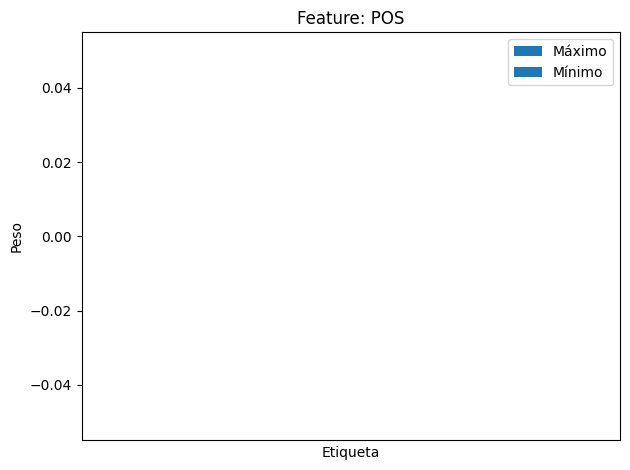

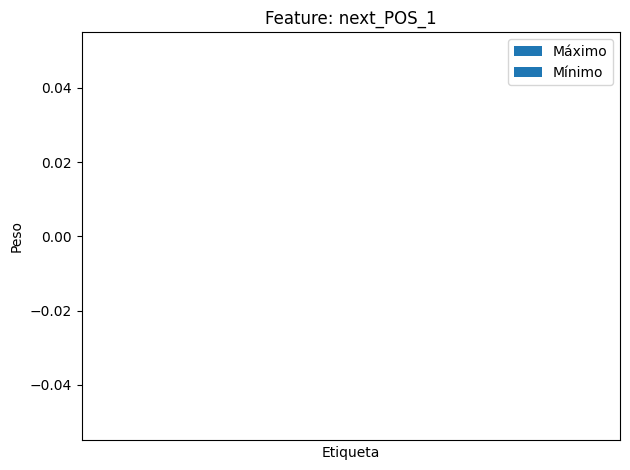

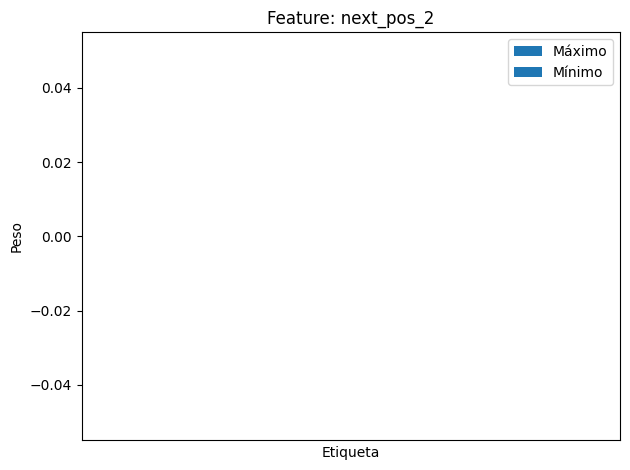

In [ ]:
feature_general = ['Prev_POS_2', "Prev_POS_1", "POS", "next_POS_1", "next_pos_2"]
D_POS = {feature: {} for feature in feature_general}  # Diccionario para almacenar los pesos de las features
# Agrupar los pesos por caracter칤sticas y etiquetas
for (e, l), v in tagger.info().state_features.items():
    if ":" in e:
        e = e.split(":")[0]
    if e in feature_general:
        D_POS[e].setdefault(l, []).append(v)
# Graficar para cada feature en feature_general el valor m치ximo y m칤nimo para cada etiqueta
for f in feature_general:
    D_ = D_POS[f]
    labels = list(D_.keys())
    max_values = [max(v) for v in D_.values()]
    min_values = [min(v) for v in D_.values()]
    # Crear un gr치fico de barras
    x = range(len(labels))  # Posiciones en el eje x
    width = 0.35  # Ancho de las barras
    plt.bar(x, max_values, width, label='M치ximo', color='red', alpha=0.7)
    plt.bar([p + width for p in x], min_values, width, label='M칤nimo', color='blue', alpha=0.7)
    
    plt.title(f"Feature: {f}")
    plt.xlabel("Etiqueta")
    plt.ylabel("Peso")
    plt.xticks([p + width / 2 for p in x], labels)  # Ajustar las etiquetas en el eje x
    plt.legend()
    plt.tight_layout()
    plt.show()

El modelo s칤 que aporta pesos significativos a las features asociadas a los POS tags del contexto, pero sobretodo la magnitud de los pesos es mayor para los features con POS tag actual.

Por otro lado, podemos intuir que la incorporaci칩n de los postags puede introducir algo de ruido en el modelo, por ejemplo:

('POS:NC', 'B-LOC') 0.572978<br>
('POS:NC', 'O') -1.01741<br>
('POS:NC', 'B-ORG') -0.461251<br>
('POS:NC', 'B-PER') 0.635075<br>
('POS:NC', 'I-PER') 0.484962<br>
('POS:NC', 'B-MISC') -0.869603<br>
('POS:NC', 'I-ORG') -0.08641<br>
('POS:NC', 'I-LOC') 0.328815<br>
('POS:NC', 'I-MISC') 0.412843<br>


Los postags asociados a NC tienen un peso bastante parecido para las etiquetas 'B-LOC', 'B-PER', 'I-PER'y 'I-MISC'. Ejemplos como este no le permiten al modelo discriminar bien.

In [ ]:
besttagger = pycrfsuite.Tagger()
besttagger.open('Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger')
best_weights = tagger.info().state_features

Ahora se van a analizar los pesos del mejor modelo:

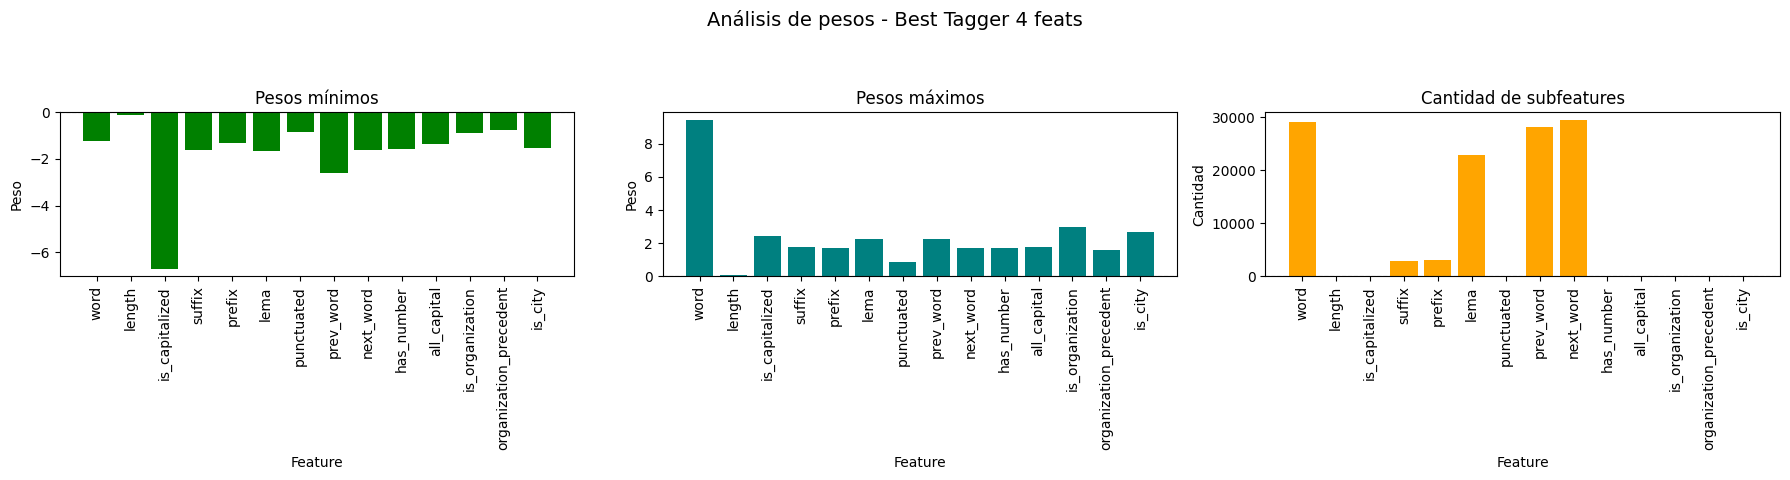

In [ ]:
taggers = [besttagger]
titles = ["Best Tagger 4 feats"] 

for t_i, t in enumerate(taggers):
    D = {}

    for k, v in t.info().state_features.items():
        e, _ = k
        if ":" in e:
            e = e.split(":")[0]
        if e in D:
            D[e].append(v)
        else:
            D[e] = [v]

    D_max = {k: max(v) for k, v in D.items()}
    D_min = {k: min(v) for k, v in D.items()}
    D_len = {k: len(v) for k, v in D.items()}

    # Crear una fila con 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"An치lisis de pesos - {titles[t_i]}", fontsize=14)

    # Subplot 1: Pesos m칤nimos
    axes[0].bar(D_min.keys(), D_min.values(), color='green')
    axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[0].set_title("Pesos m칤nimos")
    axes[0].set_ylabel("Peso")
    axes[0].set_xlabel("Feature")
    axes[0].tick_params(axis='x', rotation=90)

    # Subplot 2: Pesos m치ximos
    axes[1].bar(D_max.keys(), D_max.values(), color='teal')
    axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[1].set_title("Pesos m치ximos")
    axes[1].set_ylabel("Peso")
    axes[1].set_xlabel("Feature")
    axes[1].tick_params(axis='x', rotation=90)

    # Subplot 3: Cantidad de subfeatures
    axes[2].bar(D_len.keys(), D_len.values(), color='orange')
    axes[2].axhline(0, color='gray', linestyle='--', linewidth=0.8)
    axes[2].set_title("Cantidad de subfeatures")
    axes[2].set_ylabel("Cantidad")
    axes[2].set_xlabel("Feature")
    axes[2].tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Ajustar para que no se solape con suptitle
    plt.show()


Se ve que el modelo est치 basando sus decisiones principalmente en las palabras mismas y su contexto l칠xico inmediato. Se crea una mayor cantidad de features asociados a la palabra actual, la anterior o la siguiente. Esto, podria ser causa de un posible sobreajuste a los datos de entrenamiento. El modelo est치 aprendiendo patrones espec칤ficos de palabras en lugar de patrones gramaticales o estructurales m치s generales. El modelo podr칤a funcionar bien con vocabulario visto durante el entrenamiento pero fallar con palabras nuevas.

Adem치s, se consideran bastante importantes todas las features b치sicas, menos la feature que indica si la palabra tiene un n칰mero o no.

Podemos ver como afectan las caracter칤sticas espec칤ficas. Vamos a analizar los pesos que aporta el modelo a estas features. Necesitamos que la etiqueta que, en este caso ORG y LOC, tenga un peso grande y positivo ya que entonces el modelo aporta mucha probabilidad a favor de esta etiqueta, y adem치s queremos que el peso de la feature para las dem치s etiquetas sea negativo para bajar la probabilidad de las etiquetas incorrectas. 

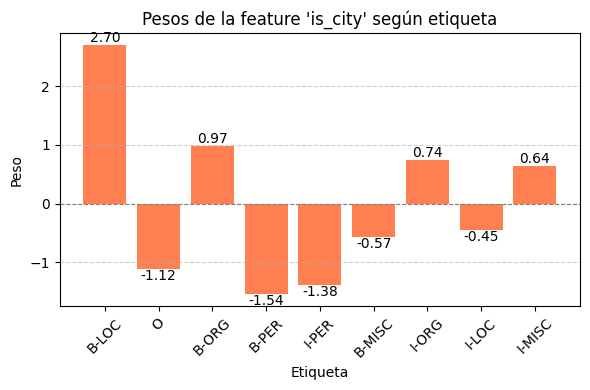

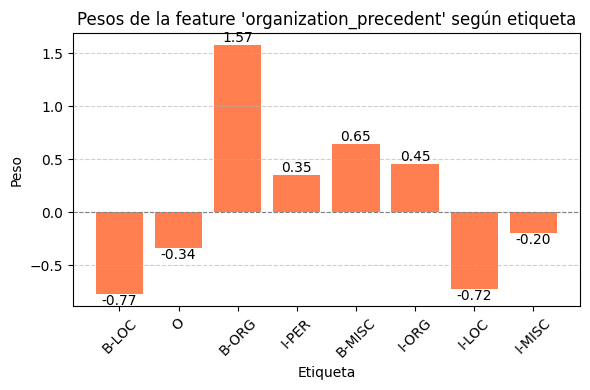

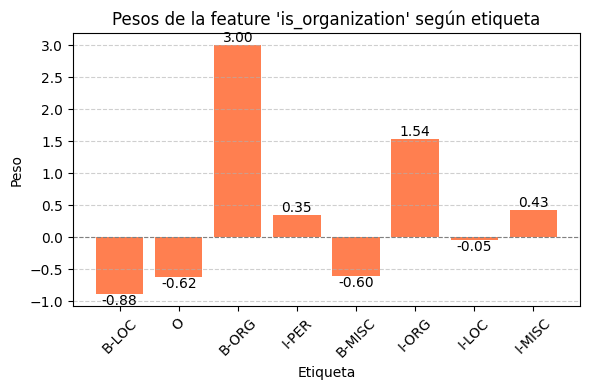

In [ ]:

feature_general = ["is_city","organization_precedent","is_organization"]
weights = besttagger.info().state_features
for f in feature_general:
    # Extraemos etiquetas y pesos
    labels = []
    values = []

    for (feature_label, tag), weight in weights.items():
        if feature_label.startswith(f):
            labels.append(tag)
            values.append(weight)

    # Gr치fico
    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color='coral')
    plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')
    plt.title(f"Pesos de la feature '{f}' seg칰n etiqueta")
    plt.ylabel("Peso")
    plt.xlabel("Etiqueta")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Mostrar valor en cada barra
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.2f}', ha='center',
                va='bottom' if value >= 0 else 'top')

    plt.tight_layout()
    plt.show()

Vemos que el modelo usa el bloque de las caracter칤sticas espec칤ficas para aprender las probabilidades, tambi칠n, de otras etiquetas que no se refieren a las entidades de organizaci칩n ni localizaci칩n. Este comportamiento puede ser adecuado para las etiquetas micelanas, pero podr칤a introducir ruido en el caso de otras etiquetas.

- El modelo al Gazzetter relacionado con el pa칤s aporta correctamente bastante peso a la etiqueta del inicio de organizaci칩n, pero podr칤a aportar ruido ya que le asigna peso a las etiquetas "B-ORG" y "I-MISC", sin embargo este es un comportamiento bastante esperado ya que, como vimos en el fichero del train muchas palabras marcadas localizaciones podr칤an ser organizaciones a la vez.

- El modelo aporta un peso bastante significativo al Gazzetter con organizaciones (is_organization), a las etiquetas adecuadas. Con algo de ruido en las etiquetas "I-PER", "I-MISC".

- Los trigramas precedentes a las organizaciones aportan menos peso de todo el bloque de las caracter칤sticas espec칤ficas. Puede ser debido a que otras caracter칤sticas, como las palabras del contexto, ya est칠n captando esta informaci칩n. Tambi칠n puede ser causa de la gran variablilidad de los trigramas precedentes y poca cobertura del Gazzetter ya que contiene solo unas pocas frases precedentes.

Adem치s, analizaremos los pesos del feature "lema":

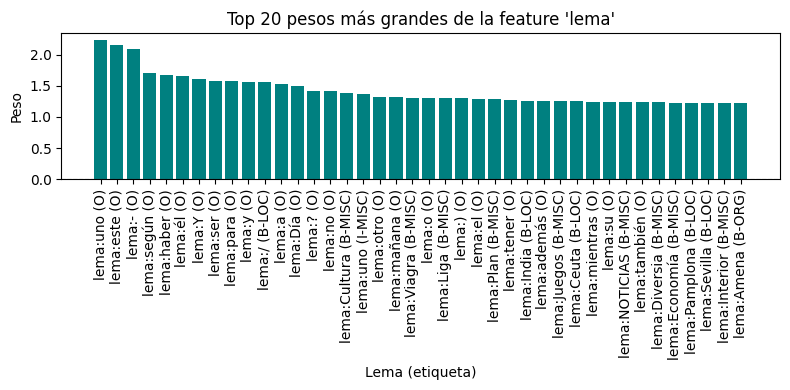

In [ ]:
parsed_info = besttagger.info()
state_features = parsed_info.state_features

# Extraer solo los pesos de la feature 'lema'
lema_weights = {key: weight for key, weight in state_features.items() if key[0].startswith('lema')}

# Ordenar por el valor (no absoluto), de mayor a menor
top_20_lemas = sorted(lema_weights.items(), key=lambda x: x[1], reverse=True)[:40]

# Preparar datos para el plot
features = [f"{feature} ({label})" for (feature, label), weight in top_20_lemas]
weights = [weight for (feature, label), weight in top_20_lemas]

plt.figure(figsize=(8, 4))
bars = plt.bar(features, weights, color='teal')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title("Top 20 pesos m치s grandes de la feature 'lema'")
plt.ylabel("Peso")
plt.xlabel("Lema (etiqueta)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



- Los pesos de los lemas tienden a ser m치s moderados lo que podr칤a significar que la informaci칩n ya est치 captada por otros features, como por ejemplo "word" que en algunos casos tienen los mismos valores.
- Esta feature termina de captar las palabras no incluidas en los Gazzetters relacionados con la localizaci칩n y las organizaciones. 
- Los lemas muestran pesos significativos para etiquetas "O", lo que significa que aportan a la desici칩n de los l칤mite de las entidades. 

## 7. Full Analysis with Optimized Features

Now that we've identified the best feature combinations, we can train a model with the optimal configuration and evaluate it on the full test set.

Como comentabamos anteriormente, buscamos los mejores features a base de addici칩n, y lo avaluamos con los datos de validaci칩n, obtenemos el modelo con mejor score F1 y lo predecimos para los datos test como validaci칩n del modelo. El siguiente chunk implementa una simple predicci칩n y lo compara con los datos del test. 
IMPORTANTE: Se carga el mejor modelo preentrenado, problema, el crf.tagger no almacena la combinaci칩n optima de features, se tiene que configurar a mano, seg칰n el corpus de entrada, mediante la variable optimal_feat_func.  

## 8. Experiment with Different Tag Encoding Schemes

En este apartado se implementa el experimento con diferentes esquemas de codificaci칩n de etiquetas. Aqu칤 entrenamos nuestro modelo con los datos de train transformados a las diferentes codificaciones. Se aplicar치 la mejor combinaci칩n de features obtenida para la codificaci칩n BIO, para optimizar el tiempo. Una vez, entrenados los modelos, se predice para los datos del test. Se extrae los NE de las predicciones y se compara con los NE del test extra칤dosa partir de la codificaci칩n BIO anteriormente (dentro del proceso de evaluaci칩n).

Sospechamos que habr치 problema con la codificaci칩n IO ya que aporta ambig칲edad a la hora de extraer entidades. No determina objetivamente donde empieza una entidad, por tanto, cuando hay m칰ltiples entidades consecutivas, las podr칤a fusionar y se perder치n entidades.

**Esquemas:**

Esquema BIO (base de datos)
- B: Beginning (inicio de una entidad)
- I: Inside (continuaci칩n de una entidad)
- O: Outside (fuera de cualquier entidad)

IO
- I: Inside (token que pertenece a una entidad)
- O: Outside (token que no pertenece a una entidad)

BIOE
- B-: Beginning (primer token de una entidad)
- I-: Inside (tokens intermedios)
- E-: End (칰ltimo token de una entidad)
- O: Outside (fuera de cualquier entidad)

BIOES
- B: Beginning (primer token de una entidad multi-token)
- I: Inside (tokens intermedios de una entidad multi-token)
- O: Outside (no es parte de ninguna entidad)
- E: End (칰ltimo token de una entidad multi-token)
- S: Singleton (entidad de un solo token)

BIOW
- B: Beginning (primer token de una entidad multi-token)
- I: Inside (tokens intermedios de una entidad multi-token)
- O: Outside (no es parte de ninguna entidad)
- W: Whole (entidad de un solo token)

# Conclusion

1. Aunque ya predice bastante biien las O's, pero es coherente que haya confusi칩n entre las etiquetas de organizaci칩n y localizaci칩n, ya que muchas veces son las mismas palabras. Se puede visualizar en la AED en el apartado de SimpleGazzeters.
2. Muchos O's se confunden como organizaciones, ORG es la etiqueta que tiene m치s apariencia en el corpus y por tanto tiene mayor probabilidad de ser etiquetada como tal, teninedo en cuenta que la mayor칤a de las palabras que no son entidades son etiquetadas como O, entonces se han solapado estas probabilidades.
## VER QU칄 TOKENS DE ORG HAN FALLADO.

3. IO existe ambiguedad en extraer las entidades, y ha fusionado las etiquetas de las entidades tal que se ha reducido significativamente el n칰mero de entidades. 
## grafica de como se ha reducido el n칰mero de entidades, y como se han fusionado las etiquetas.

4. Entre tags no hay mucha diferencia porque ya contienen BIO y posiblemente por la falta de muestra de los Singletons, no mejora la predicci칩n a침adiendo m치s etiquetas relativas a singletons.
## PROPORCI칍N de singleton (apartado 1)

In [7]:
if __name__== "__main__":
    # Run the main function
    # Load the Spanish NER data
    print("========================Loading Spanish NER data...=================================")
    test = conll2002.iob_sents('esp.testb')

    print(f"Training set: {len(train)} sentences")
    print(f"Test set: {len(test)} sentences")
    print(f"Validation set: {len(val)} sentences")

    # Show an example sentence
    print("\nExample sentence:")
    print(train[0])

    #process the training data with lemmatization 
    preprocessed_test = prepare_data_for_crf(test, True)


    train_completo(processed_train=processed_train, processed_val=preprocessed_val)



========================Loading Spanish NER data...=================================
Training set: 8323 sentences
Test set: 1517 sentences
Validation set: 1915 sentences

Example sentence:
[('Melbourne', 'NP', 'B-LOC'), ('(', 'Fpa', 'O'), ('Australia', 'NP', 'B-LOC'), (')', 'Fpt', 'O'), (',', 'Fc', 'O'), ('25', 'Z', 'O'), ('may', 'NC', 'O'), ('(', 'Fpa', 'O'), ('EFE', 'NC', 'B-ORG'), (')', 'Fpt', 'O'), ('.', 'Fp', 'O')]
Starting greedy feature selection...

--- Finding best configuration with 0 features ---
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 1


KeyboardInterrupt: 

Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


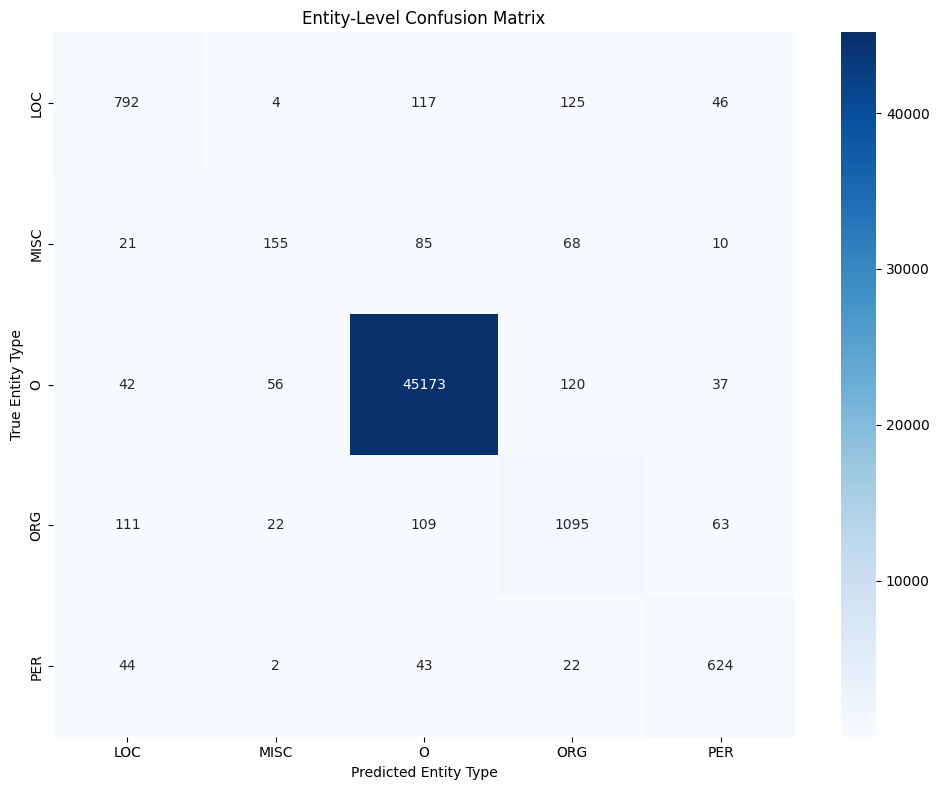


Most common entity type confusions:
Original (BIO):
[('Por', 'SP', 'O'), ('su', 'DP', 'O'), ('parte', 'NC', 'O'), (',', 'Fc', 'O'), ('el', 'DA', 'O'), ('Abogado', 'NC', 'B-PER'), ('General', 'AQ', 'I-PER'), ('de', 'SP', 'O'), ('Victoria', 'NC', 'B-LOC'), (',', 'Fc', 'O'), ('Rob', 'NC', 'B-PER'), ('Hulls', 'AQ', 'I-PER'), (',', 'Fc', 'O'), ('indic칩', 'VMI', 'O'), ('que', 'CS', 'O'), ('no', 'RN', 'O'), ('hay', 'VAI', 'O'), ('nadie', 'PI', 'O'), ('que', 'PR', 'O'), ('controle', 'VMS', 'O'), ('que', 'CS', 'O'), ('las', 'DA', 'O'), ('informaciones', 'NC', 'O'), ('contenidas', 'AQ', 'O'), ('en', 'SP', 'O'), ('CrimeNet', 'NC', 'B-MISC'), ('son', 'VSI', 'O'), ('veraces', 'AQ', 'O'), ('.', 'Fp', 'O')]

IO Scheme:
[('Por', 'SP', 'O'), ('su', 'DP', 'O'), ('parte', 'NC', 'O'), (',', 'Fc', 'O'), ('el', 'DA', 'O'), ('Abogado', 'NC', 'I-PER'), ('General', 'AQ', 'I-PER'), ('de', 'SP', 'O'), ('Victoria', 'NC', 'I-LOC'), (',', 'Fc', 'O'), ('Rob', 'NC', 'I-PER'), ('Hulls', 'AQ', 'I-PER'), (',', 'Fc', 'O

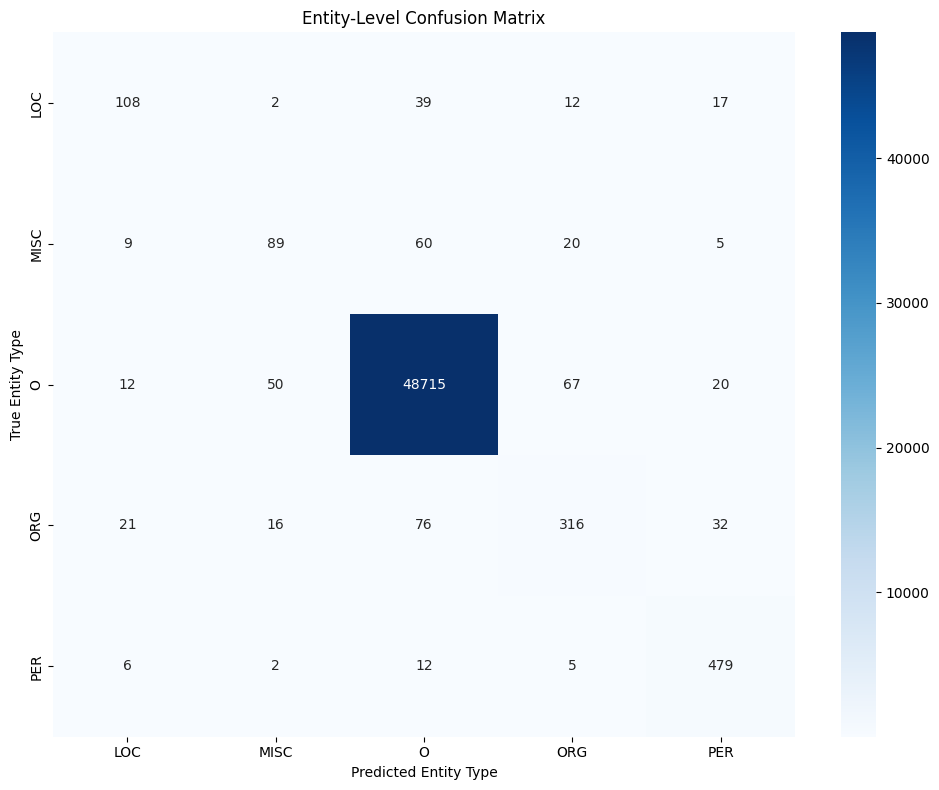


Most common entity type confusions:

Results for IO tagging scheme:
Precision: 0.7702
Recall: 0.7481
F1 Score: 0.7590

Processing BIOE tagging scheme...
Training model with BIOE tagging scheme...
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


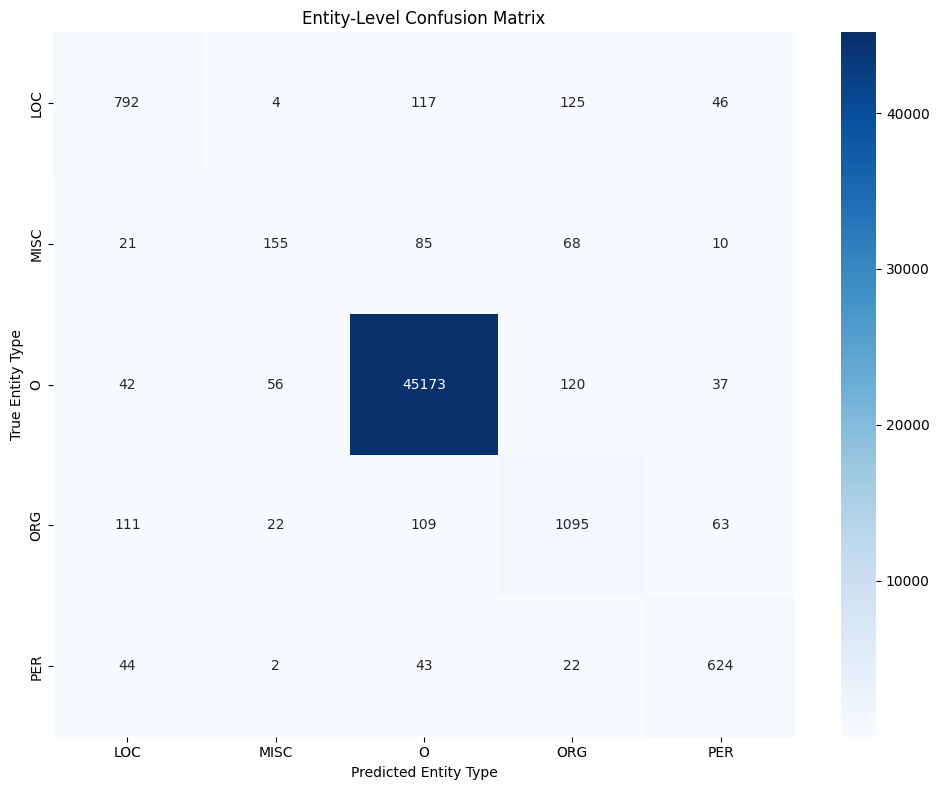


Most common entity type confusions:

Results for BIOE tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

Processing BIOES tagging scheme...
Training model with BIOES tagging scheme...
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


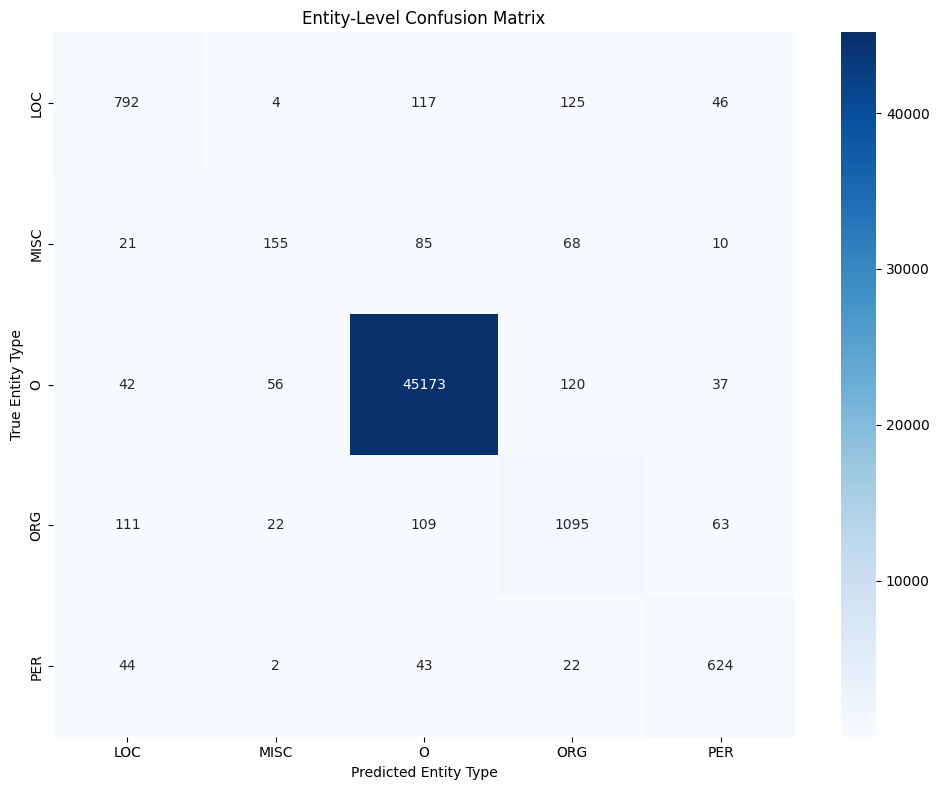


Most common entity type confusions:

Results for BIOES tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

Processing BIOW tagging scheme...
Training model with BIOW tagging scheme...
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


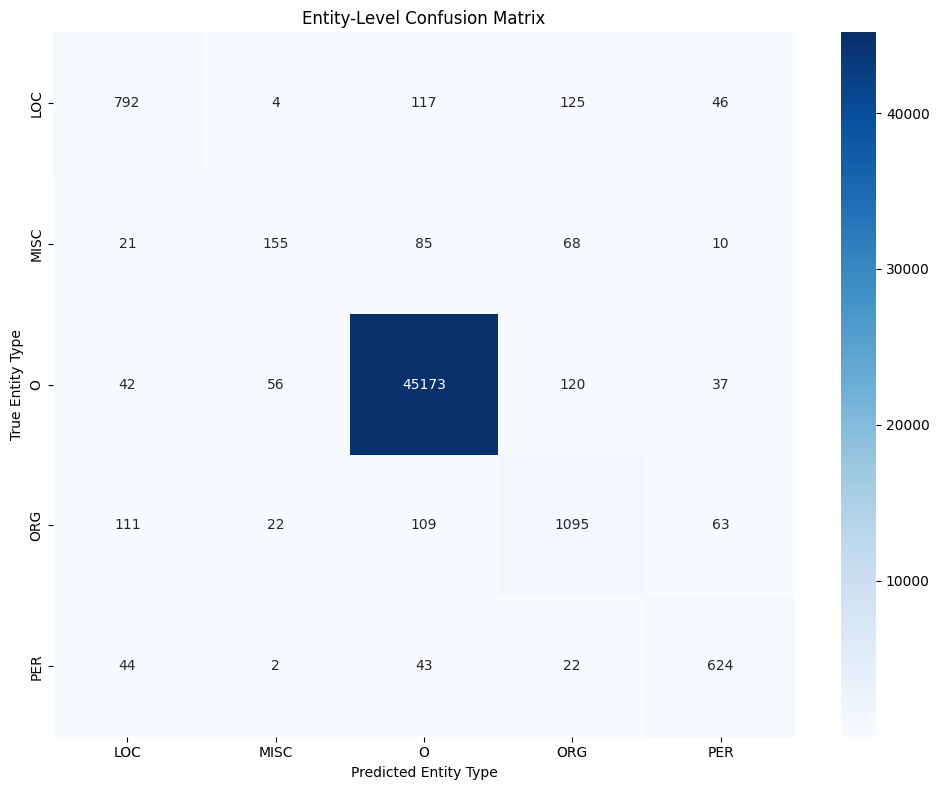


Most common entity type confusions:

Results for BIOW tagging scheme:
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Comparison of Tagging Schemes ===
Loading pre-trained model from Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7707
Recall: 0.7493
F1 Score: 0.7599

=== Entity-Level Confusion Matrix ===


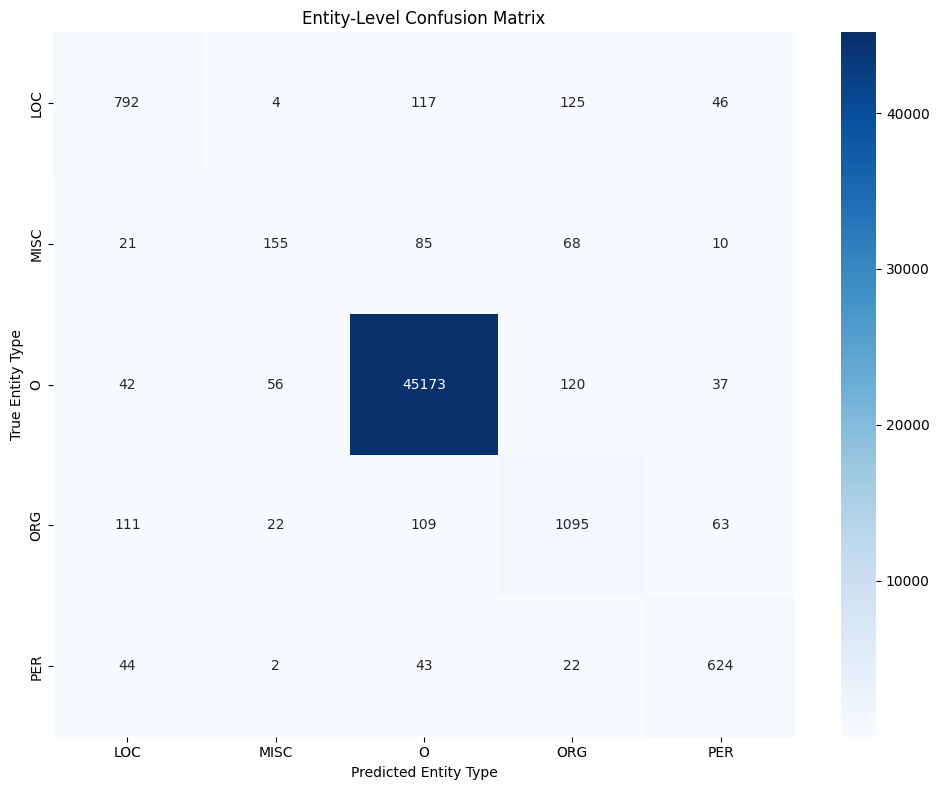


Most common entity type confusions:


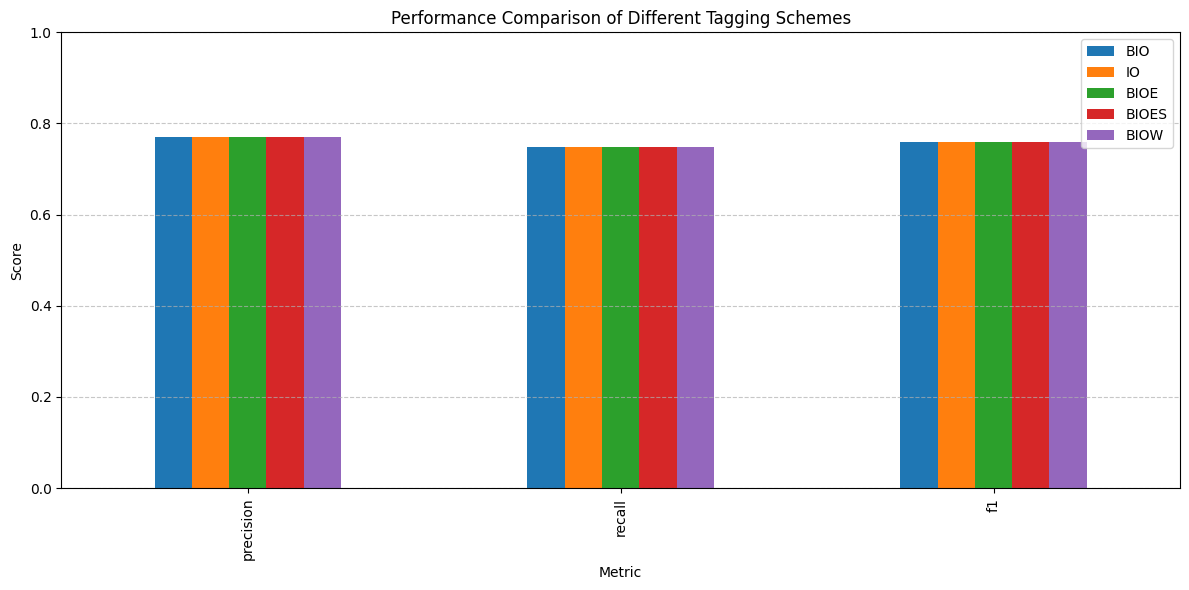

In [8]:

best_model_path = 'Modelos_Spanish/best_model_r4_B_C_L_S.crf.tagger'
results = run_optimal_configuration(model_path=best_model_path, preprocessed_test=preprocessed_test)

# Example of converting tags
sample_sent = [train[5]]  # Wrap in list to match expected input structure
print("Original (BIO):")
print(sample_sent[0])

io_sent = bio_to_io(sample_sent)
print("\nIO Scheme:")
print(io_sent[0])

bioes_sent = bio_to_bioes(sample_sent)
print("\nBIOES Scheme:")
print(bioes_sent[0])

test_results = test_with_othersCodes(train=train, 
                                        preprocessed_test=preprocessed_test, 
                                        best_model_path=best_model_path)



## NER para Neerland칠s

En el siguiente apartado tenemos el entrenamiento y evaluaci칩n completo de los modelos para neerland칠s. Se ha seguido el mismo procedimiento que para el espa침ol, pero se han utilizado diferentes caracter칤sticas. 
IMPORTANTE: Para ejecutar el modelo 칩ptimo de neerland칠s, se debe cambiar la variable "optimal_feat_func" a la combinaci칩n de features 칩ptima para neerland칠s que ser칤a todos los features de la clase OptimizedFeatFunc, menos el use_EXTRA y use_specific_caracteristics.

In [4]:
print("========================Loading Dutch NER data...=================================")
    # Load the Dutch NER data
dutch_train = conll2002.iob_sents('ned.train')
dutch_val = conll2002.iob_sents('ned.testa')
dutch_test = conll2002.iob_sents('ned.testb')
print("Preparing Dutch data...")
processed_dutch_train = prepare_data_for_crf(dutch_train, include_lemmas=True)
preprocessed_dutch_val = prepare_data_for_crf(dutch_val, True)
preprocessed_dutch_test = prepare_data_for_crf(dutch_test, True)
print("Training Dutch model...")
train_completo(processed_train=processed_dutch_train, processed_val=preprocessed_dutch_val)
best_model = 'modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger'
results = run_optimal_configuration(model_path=best_model, preprocessed_test=preprocessed_dutch_test)
print("Evaluating Dutch model with other TAGS...")
test_results = test_with_othersCodes(train=dutch_train, 
                                        preprocessed_test=preprocessed_dutch_test, 
                                        best_model_path=best_model)

========================Loading Dutch NER data...=================================
Preparing Dutch data...
Training Dutch model...
Starting greedy feature selection...

--- Finding best configuration with 0 features ---
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 1
F1 Score: 0.0526, Time: 7.83 seconds
Saved best model with 0 features to best_model_r0_.crf.tagger
Best configuration with 0 features: []
Best F1 score: 0.0526

--- Finding best configuration with 1 features ---
Testing configuration: {'Basic': True, 'Context_Words': False, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.6527, Time: 66.53 seconds
Testing configuration: {'Basic': False, 'Context_Words': True, 'Context_POS': False, 'Specific': False, 'Lemmas': False} out of 5
F1 Score: 0.3924, Time: 25.99 seconds
Testing configuration: {'Basic': False, 'Context_Words': False, 'Context_POS': True, 'Specific': Fals

KeyboardInterrupt: 

Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


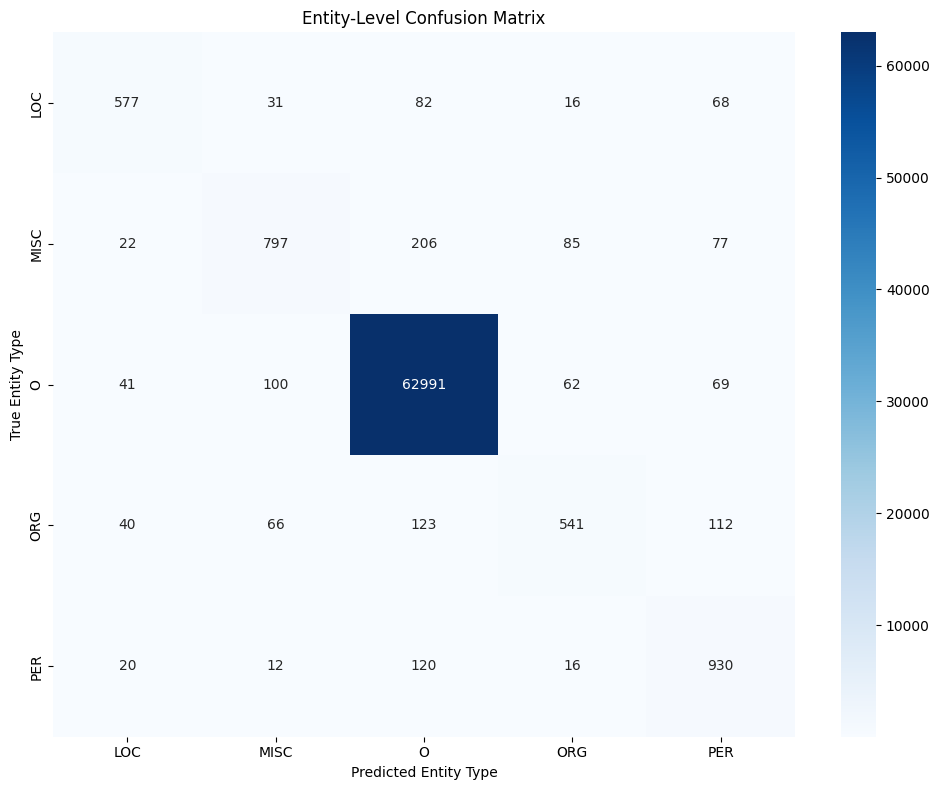


Most common entity type confusions:

Processing IO tagging scheme...
Training model with IO tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7547
Recall: 0.7413
F1 Score: 0.7480

=== Entity-Level Confusion Matrix ===


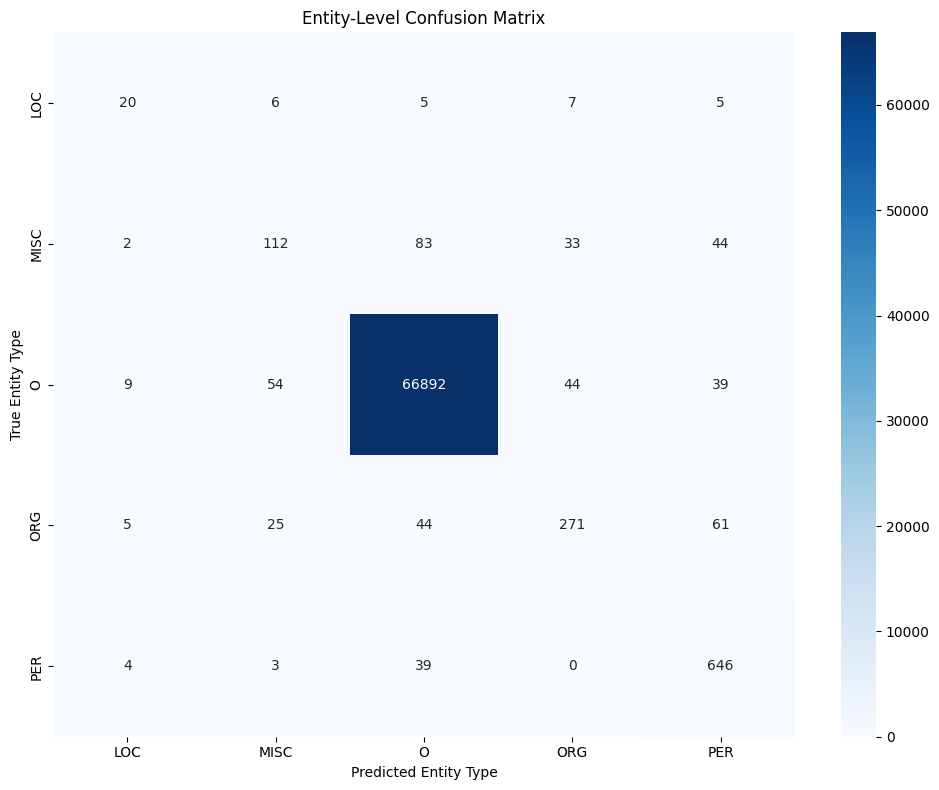


Most common entity type confusions:
  MISC mistaken as O: 83 times

Results for IO tagging scheme:
Precision: 0.7547
Recall: 0.7413
F1 Score: 0.7480

Processing BIOE tagging scheme...
Training model with BIOE tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


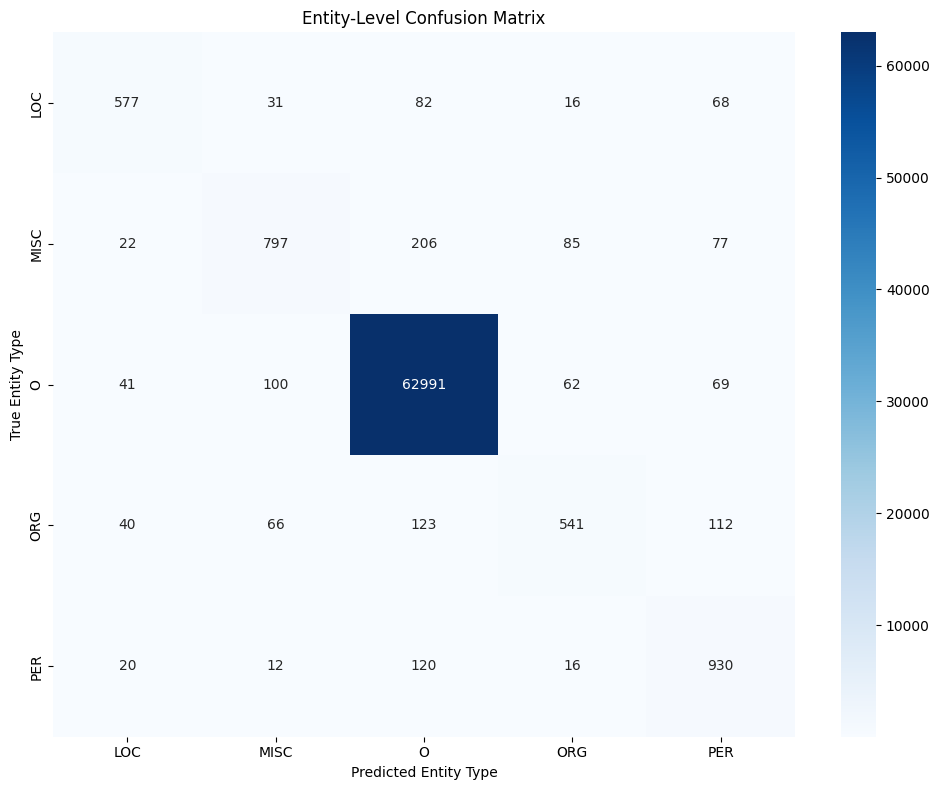


Most common entity type confusions:

Results for BIOE tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

Processing BIOES tagging scheme...
Training model with BIOES tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


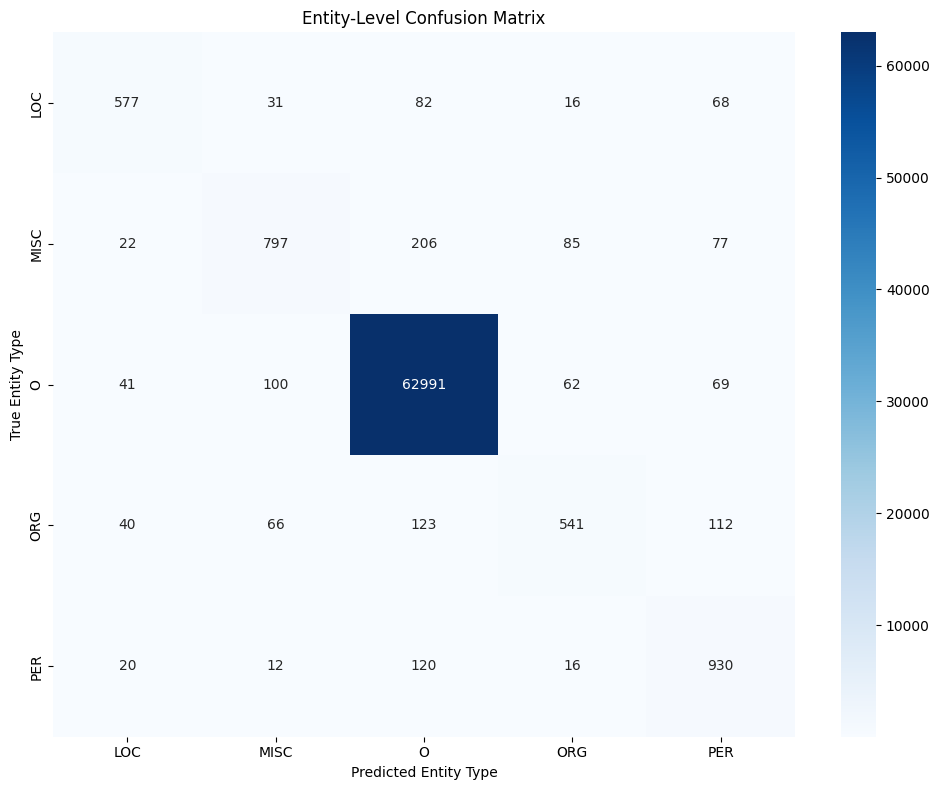


Most common entity type confusions:

Results for BIOES tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

Processing BIOW tagging scheme...
Training model with BIOW tagging scheme...
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


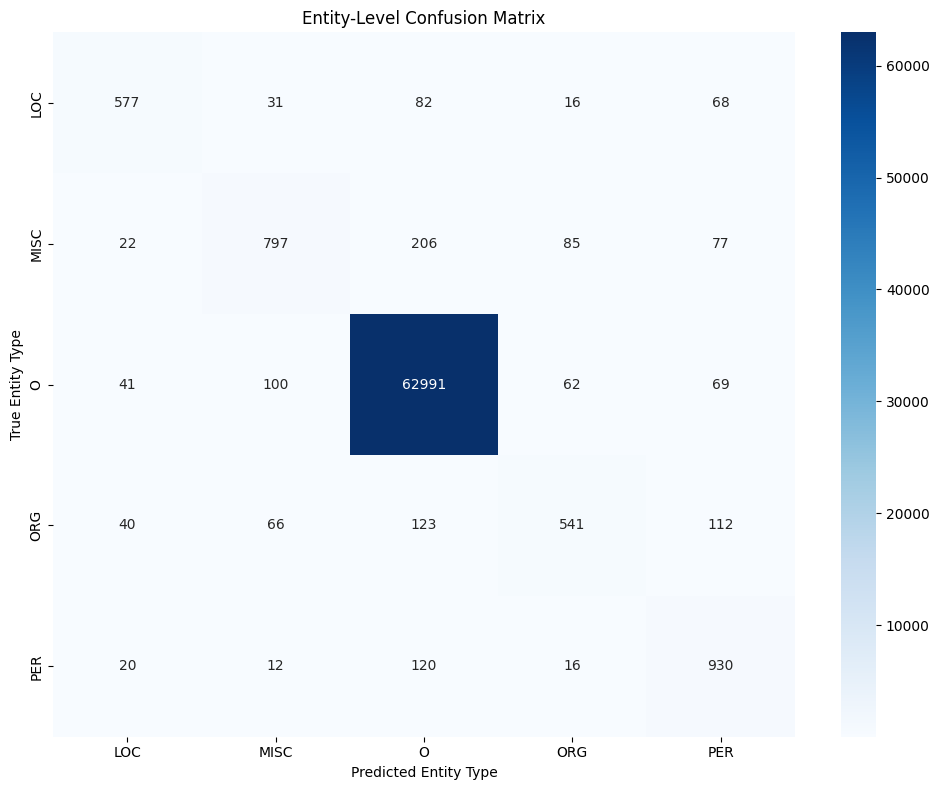


Most common entity type confusions:

Results for BIOW tagging scheme:
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Comparison of Tagging Schemes ===
Loading pre-trained model from modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger...
Evaluating model on test data...

=== Entity-Level Evaluation Results ===
Precision: 0.7727
Recall: 0.7219
F1 Score: 0.7464

=== Entity-Level Confusion Matrix ===


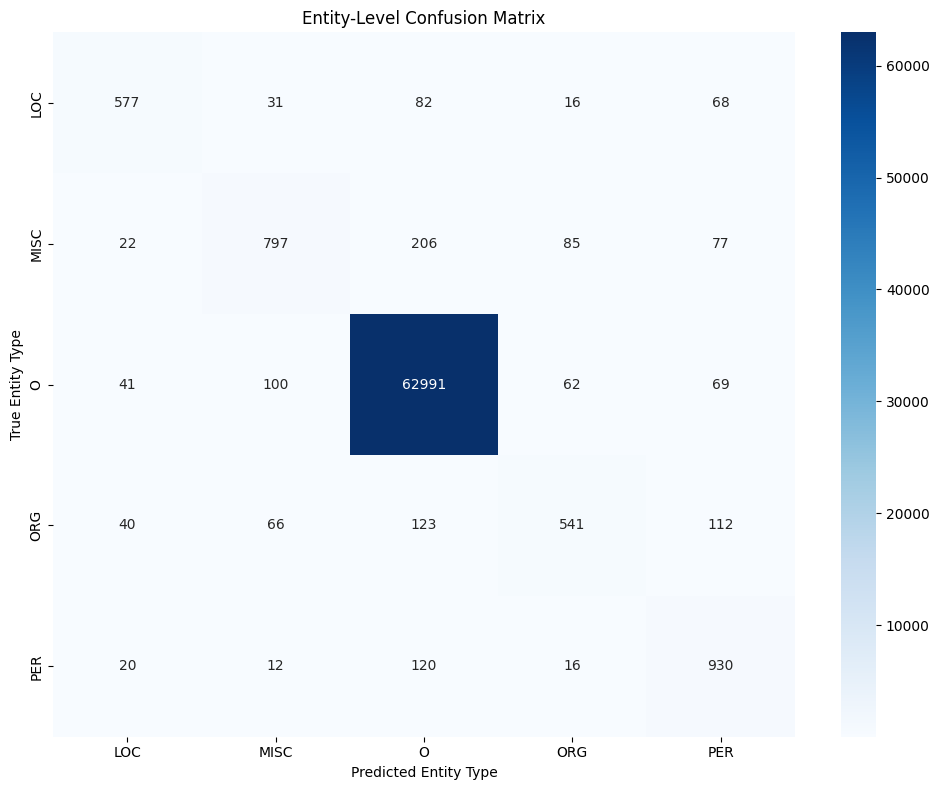


Most common entity type confusions:


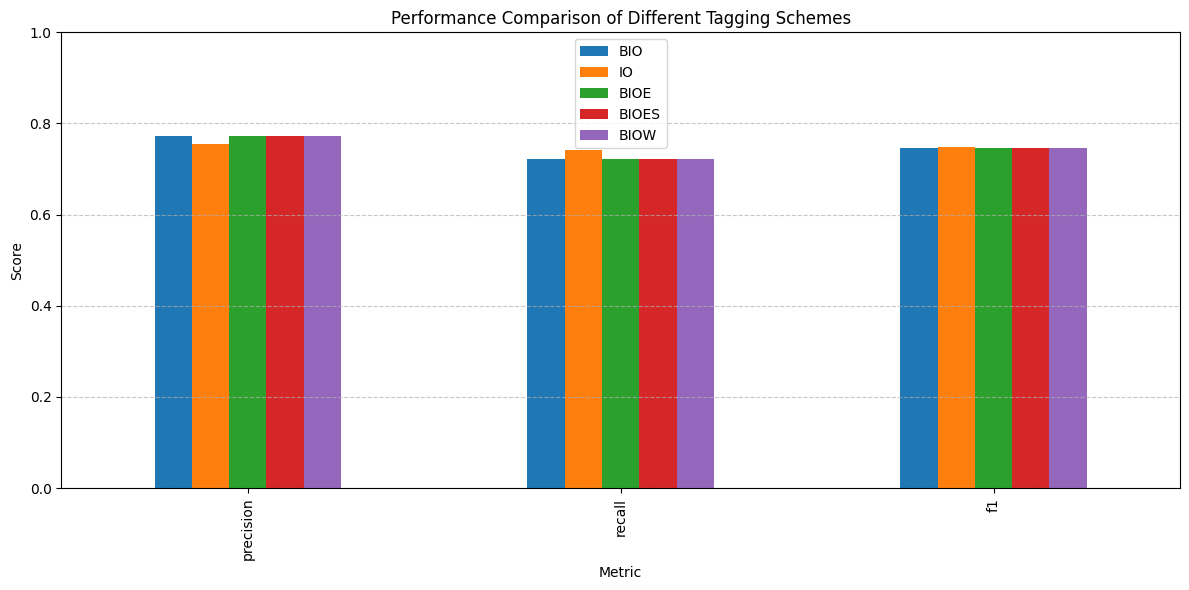

In [5]:
best_model = 'modelos_Dutch/best_model_r4_B_C_C_L.crf.tagger'

results = run_optimal_configuration(model_path=best_model, preprocessed_test=preprocessed_dutch_test)

test_results = test_with_othersCodes(train=dutch_train, 
                                        preprocessed_test=preprocessed_dutch_test, 
                                        best_model_path=best_model)